In [66]:
import torch
import torch.nn.functional as F
from model import TransformerConfig
from torch import nn
from typing import Tuple
from dataset import transform_ds
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from model import Generator
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda.amp import GradScaler
import os
import wandb

wandb.login(key="160fb2b5d5c5791978cce34bd4d7cf472ef06847")

run = wandb.init(
    project="Transformer image to image translation",
    config=vars(TransformerConfig())
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [18]:
X = 1
target = 0

In [19]:
from dataset import CarDataset
ds = CarDataset(root_dir="cars", transform=transform_ds)

train_ratio = 0.8  
train_size = int(train_ratio * len(ds))
test_size = len(ds) - train_size

train_ds, test_ds = random_split(ds, [train_size, test_size])
train_dl = DataLoader(train_ds, batch_size=TransformerConfig().train_bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=TransformerConfig().test_bs, shuffle=True)

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 321, Test size: 81


In [20]:
image = next(iter(train_dl))[X]
image.shape

torch.Size([7, 3, 256, 256])

In [21]:
gen = Generator()
sum(p.numel() for p in gen.parameters())

24980864

In [ ]:
os.makedirs("evaluate", exist_ok=True)
save_epoch = 1

In [50]:
TransformerConfig().epochs

10

In [ ]:
def save_fig(x, target, pred, folder, epoch):

    plt.subplot(1,3,1)
    plt.imshow((x.permute(1,2,0).detach().numpy())/2 + 0.5)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow((target.permute(1,2,0).detach().numpy())/2 + 0.5)
    plt.title("Target")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow((pred.permute(1,2,0).detach().numpy())/2 + 0.5)
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
    plt.savefig(f"{folder}/{str(epoch)}.png")

In [ ]:
gen = Generator()
opt_gen = optim.Adam(gen.parameters(), lr=TransformerConfig().lr, betas=(0.5, 0.999))
                     
g_scaler = GradScaler('cpu')

for epoch in range(TransformerConfig().epochs):
    total_loss = 0
    for x in train_dl:
        
        pred = gen(x[X])
        loss = torch.mean(torch.abs(X - pred))
        
        gen.zero_grad()
        g_scaler.scale(loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    if epoch % save_epoch == 0:
        save_fig(x[X][0], x[target][0], pred[0], "evaluate", epoch)
        wandb.log(
            "total": total_loss,
            "Generated Images": [wandb.Image(f"/kaggle/working/evaluate/{epoch}.png", caption=f"Epoch {epoch} - Generated")]
        )
        

In [ ]:
((x[X][0].permute(1,2,0).detach().numpy())/2 + 0.5)

(256, 256, 3)

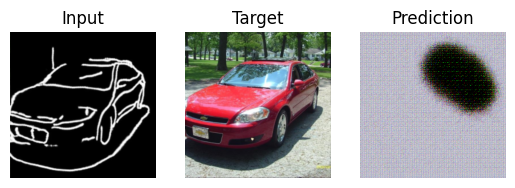

NameError: name 'epoch' is not defined

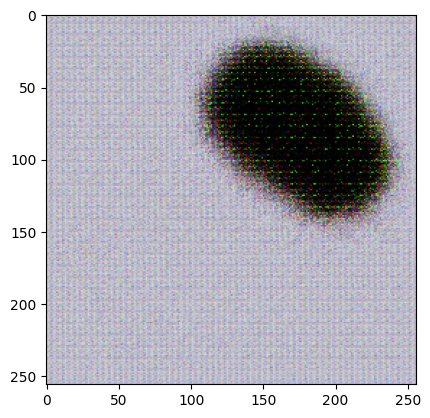

In [42]:
plt.imshow((pred[0].permute(1,2,0).detach().numpy())/2 + 0.5)

In [15]:
gen_total_loss = torch.mean(torch.abs(image - pred))
gen_total_loss

tensor(0.9435, grad_fn=<MeanBackward0>)